In [76]:
import json
import numpy as np
import matplotlib.pyplot as plt
import lightning.pytorch as pl
import torch
import gc
import wandb
import transformers as tr
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, Subset, DataLoader
from typing import Dict, List, Tuple

In [77]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [78]:
PATH_ROOT = Path(r'C:\Caesar\Machine_Learning\projects\my_cityscapes_scripts\subset')

train_annFile = PATH_ROOT / 'annotations' / 'cityscapes_panoptic_train.json'
train_masksDir = PATH_ROOT / 'annotations' / 'cityscapes_panoptic_train'

val_annFile = PATH_ROOT / 'annotations' / 'cityscapes_panoptic_val.json'
val_masksDir = PATH_ROOT / 'annotations' / 'cityscapes_panoptic_val'

test_annFile = PATH_ROOT / 'annotations' / 'cityscapes_panoptic_test.json'
test_masksDir = PATH_ROOT / 'annotations' / 'cityscapes_panoptic_test'

In [116]:
configs = {
    'max_epochs': 5,
    'batch_size': 1,
    'num_workers': 0,
    'lr': 1e-4,
    'weight_decay': 1e-4,
    'overfit_batches': 1
}

In [80]:
class CityscapesPanopticAPI:

    def __init__(self, root, annFile, masksDir):
        self.root = root
        self.annFile = annFile
        self.masksDir = masksDir

        if not self.annFile.exists():
            raise FileNotFoundError(f'Annotation file not found at {self.annFile}.')

        print('loading annotations into memory...')
        with open(self.annFile, 'r') as f:
            self.annotations = json.load(f)
        print('done!')
        
        print('creating index...')
        self.categories = self.annotations['categories']
        for cat in self.categories: 
            cat['isthing'] = True if cat['isthing'] == 1 else False
        self.images = self.annotations['images']
        self.annotations = self.annotations['annotations']
        self.ids = [img['id'] for img in self.images]
        print('index created!')

    def loadImg(self, image_id):
        return self.loadImgs([image_id])[0]
    
    def loadAnn(self, image_id):
        return next(filter(lambda ann: ann['image_id'] == image_id, self.annotations), None)

    def loadImgs(self, image_ids):
        images = list(filter(lambda img: img['id'] in image_ids, self.images))
        return [Image.open(self.root / img['file_name']) for img in images]
    
    def getImageIds(self):
        return [img['id'] for img in self.images]
    
    def getCategoryById(self, category_id):
        return next((cat for cat in self.categories if cat['id'] == category_id), None)
    
    def getMask(self, filename):
        return Image.open(self.masksDir / filename)
    
    def id2color(self, category_id):
        cat = self.getCategoryById(category_id)
        return cat['color']

    def __getitem__(self, image_id):
        return self.loadImg(image_id), self.loadAnn(image_id)

In [81]:
train_cityscapesAPI = CityscapesPanopticAPI(PATH_ROOT, train_annFile, train_masksDir)

loading annotations into memory...
done!
creating index...
index created!


In [82]:
train_cityscapesAPI.categories

[{'id': 0,
  'name': 'road',
  'supercategory': 'flat',
  'isthing': False,
  'color': [0.5019607843137255, 0.25098039215686274, 0.5019607843137255]},
 {'id': 1,
  'name': 'sidewalk',
  'supercategory': 'flat',
  'isthing': False,
  'color': [0.9568627450980393, 0.13725490196078433, 0.9098039215686274]},
 {'id': 2,
  'name': 'building',
  'supercategory': 'construction',
  'isthing': False,
  'color': [0.27450980392156865, 0.27450980392156865, 0.27450980392156865]},
 {'id': 3,
  'name': 'wall',
  'supercategory': 'construction',
  'isthing': False,
  'color': [0.4, 0.4, 0.611764705882353]},
 {'id': 4,
  'name': 'fence',
  'supercategory': 'construction',
  'isthing': False,
  'color': [0.7450980392156863, 0.6, 0.6]},
 {'id': 5,
  'name': 'pole',
  'supercategory': 'object',
  'isthing': False,
  'color': [0.6, 0.6, 0.6]},
 {'id': 6,
  'name': 'traffic light',
  'supercategory': 'object',
  'isthing': False,
  'color': [0.9803921568627451, 0.6666666666666666, 0.11764705882352941]},
 {'i

In [83]:
class CityscapesPanopticDataset(Dataset):

    def __init__(self, cityscapesAPI: CityscapesPanopticAPI, feature_extractor=None) -> None:
        self.cityscapesAPI = cityscapesAPI
        self.feature_extractor = feature_extractor
        self.image_ids = [img['id'] for img in self.cityscapesAPI.images]
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image, target = self.cityscapesAPI[self.image_ids[idx]]

        if self.feature_extractor:
            encoding = self.feature_extractor(
                images=[image], 
                annotations=target, 
                masks_path=self.cityscapesAPI.masksDir,
                return_tensors="pt")
            
            return encoding["pixel_values"].squeeze(), encoding["labels"][0]
        else:
            return image, target

In [84]:
train_dataset = CityscapesPanopticDataset(train_cityscapesAPI)

In [85]:
img, target = train_dataset[0]

In [86]:
target.keys()

dict_keys(['image_id', 'file_name', 'segments_info'])

In [87]:
def gtFinePanopticToSegmIdsMask(gtFinePanoptic):
    segmIdsMask = gtFinePanoptic[:, :, 2] * 256 * 256
    segmIdsMask += gtFinePanoptic[:, :, 1] * 256
    segmIdsMask += gtFinePanoptic[:, :, 0]
    return segmIdsMask.astype(np.uint32)

In [88]:
def segmIdsMaskToColorMask(segmIdsMask: np.ndarray, segmInfo: List[Dict[str, any]]) -> np.ndarray:
    colorMask = np.zeros((segmIdsMask.shape[0], segmIdsMask.shape[1], 3), np.float32)
    for segm in segmInfo:
        colorMask[segmIdsMask == segm['id']] = train_cityscapesAPI.id2color(segm['category_id'])

    return colorMask

In [89]:
def showAnns(image, target, include_nonThings=False):
    gtFinePanotpic = train_cityscapesAPI.getMask(target['file_name'])

    segmIdsMask = gtFinePanopticToSegmIdsMask(np.array(gtFinePanotpic))
    colorMask = segmIdsMaskToColorMask(segmIdsMask, target['segments_info'])

    plt.figure(figsize=(16, 10))
    plt.imshow(image)
    plt.imshow(colorMask, alpha=0.5)

    for segmInfo in target['segments_info']:
        category = train_cityscapesAPI.getCategoryById(segmInfo['category_id'])
        if category['isthing'] == False and not include_nonThings: 
            continue

        x, y, w, h = segmInfo['bbox']
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, color=category['color'], linewidth=2))
        plt.text(x, y, category['name'], fontsize=12, color='white')
    
    plt.axis('off')
    plt.show()

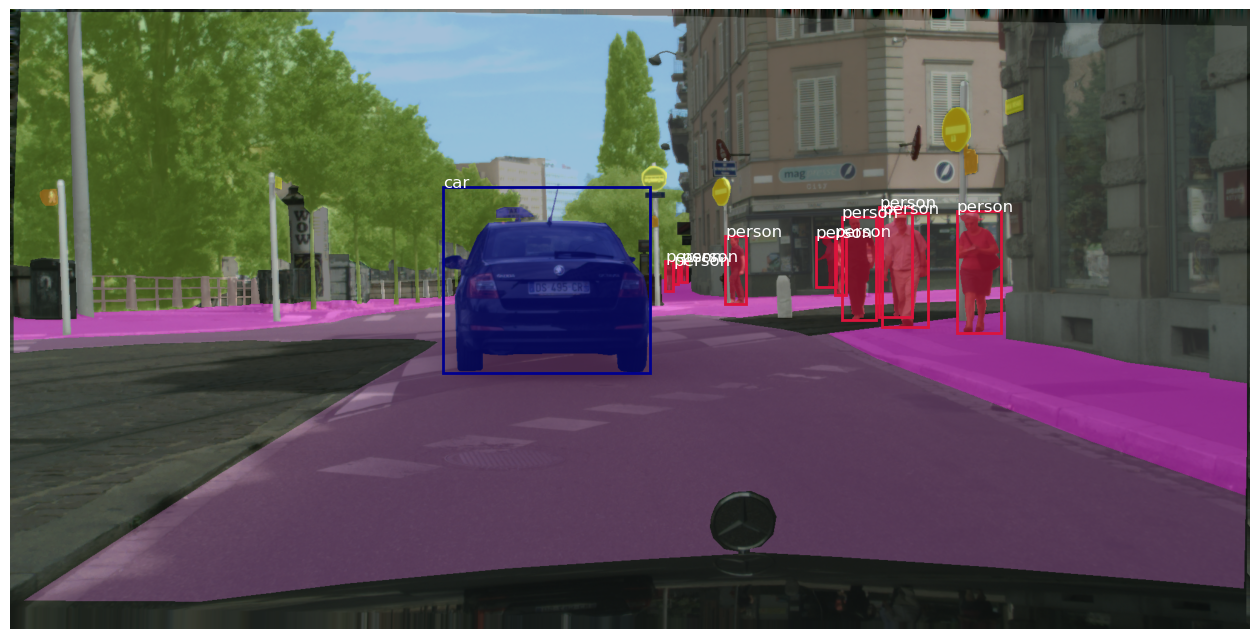

In [90]:
showAnns(img, target, include_nonThings=False)

In [91]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50-panoptic")

c:\Users\snovi\anaconda3\envs\pytorch_env\Lib\site-packages\transformers\models\detr\feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


In [92]:
def collate_fn(batch):
    pixel_values, labels = list(zip(*batch))
    encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

In [117]:
class CityscapesPanopticDataModule(pl.LightningDataModule):
    
    def __init__(self, root: Path, annFiles: Dict[str, Path], masksDirs: Dict[str, Path]):
        super().__init__()
        self.root = root
        self.cityscapesAPIs = {
            split: CityscapesPanopticAPI(root, annFile, masksDir)
            for (split, annFile), (_, masksDir) in zip(annFiles.items(), masksDirs.items())
        }
        self.datasets = {}
        
        self.feature_extractor = feature_extractor

        # metadata related to the dataset
        self.categories = self.cityscapesAPIs['train'].categories
        self.MAX_CLASS_ID = max([cat['id'] for cat in self.categories])
    
    def setup(self, stage=None):
        if stage == 'fit':
            for split in ['train', 'val']:
                self.datasets[split] = CityscapesPanopticDataset(self.cityscapesAPIs[split], self.feature_extractor)
        
        if stage == 'test':
            self.datasets['test'] = CityscapesPanopticDataset(self.cityscapesAPIs['test'], self.feature_extractor)
    
    def train_dataloader(self):
        return DataLoader(
            self.datasets['train'],
            batch_size=configs['batch_size'],
            num_workers=configs['num_workers'],
            collate_fn=collate_fn,
            shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(
            self.datasets['val'],
            batch_size=configs['batch_size'],
            num_workers=configs['num_workers'],
            collate_fn=collate_fn)
    
    def test_dataloader(self):
        return DataLoader(
            self.datasets['test'],
            batch_size=configs['batch_size'],
            num_workers=configs['num_workers'])

In [118]:
datamodule = CityscapesPanopticDataModule(
    root=PATH_ROOT,
    annFiles={'train': train_annFile, 'val': val_annFile, 'test': test_annFile},
    masksDirs={'train': train_masksDir, 'val': val_masksDir, 'test': test_masksDir}
)
datamodule.setup('fit')

loading annotations into memory...
done!
creating index...
index created!
loading annotations into memory...
done!
creating index...
index created!
loading annotations into memory...
done!
creating index...
index created!


In [95]:
batch = next(iter(datamodule.train_dataloader()))
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [96]:
batch['labels'][0].keys()

dict_keys(['size', 'image_id', 'orig_size', 'masks', 'boxes', 'class_labels', 'iscrowd', 'area'])

In [97]:
print('Shape of masks:', batch['labels'][0]['masks'].shape)
print('Shape of boxes:', batch['labels'][0]['boxes'].shape)
print('Shape of class labels:', batch['labels'][0]['class_labels'].shape)

Shape of masks: torch.Size([25, 666, 1332])
Shape of boxes: torch.Size([25, 4])
Shape of class labels: torch.Size([25])


In [98]:
wandb_logger = pl.loggers.WandbLogger(
    project='detr', 
    name='demo-detr-panoptic', 
    log_model='all')

In [99]:
artifact_dir = wandb_logger.download_artifact('suciucezar07/detr/model-ungjd87h:v2')

wandb: Downloading large artifact model-ungjd87h:v2, 158.98MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.3


In [100]:
class PanopticModel(pl.LightningModule):

    def __init__(self, lr=1e-4, weight_decay=1e-4):
        super().__init__()
        # load the pretrained detection + segmentation model from hub
        self.model = tr.DetrForSegmentation.from_pretrained(
            "facebook/detr-resnet-50-panoptic",
            num_labels=datamodule.MAX_CLASS_ID + 1, 
            ignore_mismatched_sizes=True)
        
        # load the detection module from the downloaded artifact
        detect_state_dict = torch.load(Path(artifact_dir) / 'model.ckpt')['state_dict']
        detect_state_dict = {k[5:]: v for k, v in detect_state_dict.items() if k.startswith('detr.')}
        self.model.detr.load_state_dict(detect_state_dict)
        
        self.lr = lr
        self.weight_decay = weight_decay

        # freeze the detection module
        self.model.detr.requires_grad_(False)
        
        self.save_hyperparameters()
    
    def forward(self, pixel_values, pixel_mask, labels=None):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

    def training_step(self, batch, batch_idx):
        outputs = self.model(**batch)

        self.log('train/loss', outputs['loss'], on_step=True, on_epoch=True, prog_bar=True)
        for k, v in outputs['loss_dict'].items(): 
            self.log(f'train/{k}', v, on_epoch=True)
            
        return outputs['loss']

    def validation_step(self, batch, batch_idx):
        outputs = self.model(**batch)

        self.log('val/loss', outputs['loss'], on_step=True, on_epoch=True, prog_bar=True)
        for k, v in outputs['loss_dict'].items(): 
            self.log(f'val/{k}', v, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return optimizer

In [101]:
model_pl = PanopticModel(lr=configs['lr'], weight_decay=configs['weight_decay'])

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForSegmentation were not initialized from th

In [ ]:
wandb_logger.watch(model_pl, log='all')

In [ ]:
wandb_logger.experiment.config.update(configs)

In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val/loss', mode='min')

trainer = pl.Trainer(
    max_epochs=configs['max_epochs'], 
    accelerator="auto", 
    logger=wandb_logger,
    gradient_clip_val=0.1, 
    callbacks=[checkpoint_callback],
    log_every_n_steps=1,
    overfit_batches=configs['overfit_batches'])

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
trainer.fit(model_pl, datamodule)

In [ ]:
wandb.finish()